# ANN 

This notebook will see how an ANN does on prepared dataset with the features.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys 
import pickle
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
import tqdm

sys.path.append('../')

%matplotlib inline

In [2]:
# Getting the data
data = pd.read_csv('../prepared_training_set.csv')
data.head()

,row_id,essay,word_count,LLM_written,stop_word_count,stop_word_ratio,unique_word_count,unique_word_ratio,count_question,count_exclamation,count_semi,count_colon,grammar_errors,detector_pred,anger_pred,surprise_pred,sadness_pred,fear_pred
0,1,"Dear State Senator,\n\nI'm writting to you tod...",291,1,137,0.470790,131,0.450172,0,2,0,0,2,1,0,0,0,0
1,2,"Uh, hi! So, like, summers are, like, awesome r...",311,1,137,0.440514,121,0.389068,3,4,0,0,11,0,0,0,0,0
2,3,"When peoples ask for advices, they sometimes t...",333,1,158,0.474474,155,0.465465,0,1,0,0,6,0,0,0,0,0
3,4,I think art edukation is super impotent for ki...,308,1,121,0.392857,130,0.422078,0,0,0,0,48,0,0,0,1,0
4,5,I think we should totally switch to renewable ...,307,1,138,0.449511,146,0.475570,0,2,0,0,5,1,0,0,0,0


In [3]:
# Getting the scalar 
with open('../scalars/scalar_grammar.pkl','rb') as scale_file:
    scalar = pickle.load(scale_file)

In [4]:
# Getting the numerical features
numerical = ['word_count','stop_word_count','stop_word_ratio','unique_word_count','unique_word_ratio',
             'count_question','count_exclamation','count_semi','count_colon','grammar_errors']

# Running the data through the scalar
data[numerical] = scalar.transform(data[numerical])
data.head()

,row_id,essay,word_count,LLM_written,stop_word_count,stop_word_ratio,unique_word_count,unique_word_ratio,count_question,count_exclamation,count_semi,count_colon,grammar_errors,detector_pred,anger_pred,surprise_pred,sadness_pred,fear_pred
0,1,"Dear State Senator,\n\nI'm writting to you tod...",-0.373333,1,-0.292453,0.179113,-0.500000,-0.112422,0.0,2.0,0.0,0.0,-0.285714,1,0,0,0,0
1,2,"Uh, hi! So, like, summers are, like, awesome r...",-0.284444,1,-0.292453,-0.176273,-0.621951,-0.620694,3.0,4.0,0.0,0.0,0.357143,0,0,0,0,0
2,3,"When peoples ask for advices, they sometimes t...",-0.186667,1,-0.094340,0.222358,-0.207317,0.014792,0.0,1.0,0.0,0.0,0.000000,0,0,0,0,0
3,4,I think art edukation is super impotent for ki...,-0.297778,1,-0.443396,-0.735686,-0.512195,-0.346110,0.0,0.0,0.0,0.0,3.000000,0,0,0,1,0
4,5,I think we should totally switch to renewable ...,-0.302222,1,-0.283019,-0.070665,-0.317073,0.098843,0.0,2.0,0.0,0.0,-0.071429,1,0,0,0,0


In [5]:
# Splitting data into X and y
X_train = data.drop(['essay','LLM_written','row_id'],axis=1).values
y_train = data['LLM_written'].values

# Putting both into Tensors and into a dataloader for iterating
X_tensor = torch.from_numpy(np.float32(X_train))
y_tensor = torch.from_numpy(y_train)
tensor_dataset = TensorDataset(X_tensor,y_tensor)
training_loader = DataLoader(tensor_dataset,batch_size=32,shuffle=True)

In [6]:
# Class for the model
class Model(nn.Module):
    # Constructor
    def __init__(self,num_features,model_layers,include_dropout,dropout_rate):
        # Calling super constructor
        super().__init__()
        self.model = nn.Sequential()

        # Adding the layers
        in_features = num_features
        for index in range(len(model_layers)):
            model_layer = nn.Linear(in_features,model_layers[index],bias=True)
            self.model.append(model_layer)
            self.model.append(nn.ReLU())
            in_features = model_layers[index]

            # Adding dropout if specified
            if include_dropout[index]:
                self.model.append(nn.Dropout(p=dropout_rate))
        
        # Adding the final layer
        self.model.append(nn.Linear(in_features,2))

    # Forward class
    def forward(self,X):
        # Running the input through the model 
        return self.model(X)

In [7]:
# Defining the model
num_features = X_train.shape[1]
layers = [10,20,10]
include_dropout = [True] * 3
dropout_rate = 0.2

model = Model(num_features,layers,include_dropout,dropout_rate)
model

Model(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [8]:
# Model training
EPOCHS = 10
LEARNING_RATE = 0.003
LOSS = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(),LEARNING_RATE)
history = []

for epoch in tqdm.tqdm(range(EPOCHS)):
    epoch_loss = 0
    for X,y in training_loader:
        # Making predictions
        pred = model(X)

        # Getting the loss
        loss = LOSS(pred,y.long())

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        OPTIMIZER.step()

        # Clear the gradients
        OPTIMIZER.zero_grad()

        # Adding the loss
        epoch_loss += loss.item()
    
    # Appending the average example loss to the history
    print(f'EPOCH {epoch} loss: {epoch_loss / len(tensor_dataset)}')
    history.append(epoch_loss / len(tensor_dataset))


/Users/jinalshah/.pyenv/versions/3.10.0/envs/authentic-ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [00:06<00:57,  6.36s/it]

EPOCH 0 loss: 0.006293049785972678


 20%|██        | 2/10 [00:13<00:53,  6.65s/it]

EPOCH 1 loss: 0.004450705626069916


 30%|███       | 3/10 [00:19<00:45,  6.45s/it]

EPOCH 2 loss: 0.004344402054682994


 40%|████      | 4/10 [00:26<00:39,  6.59s/it]

EPOCH 3 loss: 0.004258986082727554


 50%|█████     | 5/10 [00:33<00:34,  6.98s/it]

EPOCH 4 loss: 0.0043234542349758235


 60%|██████    | 6/10 [00:40<00:27,  6.77s/it]

EPOCH 5 loss: 0.0042299356447129234


 70%|███████   | 7/10 [00:46<00:19,  6.58s/it]

EPOCH 6 loss: 0.0042532555030537185


 80%|████████  | 8/10 [00:52<00:12,  6.43s/it]

EPOCH 7 loss: 0.004237245718934311


 90%|█████████ | 9/10 [00:58<00:06,  6.33s/it]

EPOCH 8 loss: 0.004224362249436103


100%|██████████| 10/10 [01:04<00:00,  6.46s/it]

EPOCH 9 loss: 0.004163728993879288


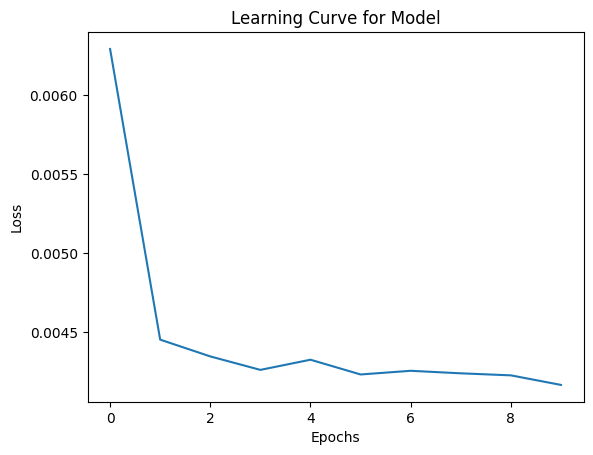

In [9]:
# Checking the learning rate
plt.plot(history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve for Model')
plt.show()

In [11]:
# Making predictions and checking the ROC AUC score
predictions = nn.functional.softmax(model(torch.from_numpy(np.float32(X_train))),dim=1).detach().numpy()[:,1]
print(f'Train ROC AUC: {roc_auc_score(y_tensor,predictions)}')

Train ROC AUC: 0.9865846460888862


In [12]:
# Saving the model
torch.save(model.state_dict(),'../models/ann.pt')